# import

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, scipy, math, sklearn
import pickle as pkl

data_directory = '/data'
processed_data_directory = r'data/processed data/'
model_directory = r'data/models/'
review_model_directory = r'data/models/review_model/'
agg_model_directory = r'data/models/aggregate_model/'

import spacy
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
STOP_WORDS = STOP_WORDS.union({'ll', 've'})

def a_lemmatizer(doc):
    doc_cleaned = ' '.join(re.findall(r'\b\w[\w\']+\b', doc))
    return [ w.lemma_.lower() for w in nlp(doc_cleaned) 
                      if (w.lemma_ not in ['_', '.']) and (w.pos_ not in ['PRON','DET','NUM','AUX','ADP']) ]

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor, LogisticRegression
from sklearn import datasets, tree, utils
from sklearn import model_selection, ensemble
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import r2_score
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [3]:
import gensim.parsing.preprocessing as gsp

In [4]:
# this file contains get_reviews, which queries the Yelp API to get a business ID and matches that with reviews from the academic dataset
import yelp_query

In [5]:
## clean up text
STOP_WORDS = STOP_WORDS.union({'ll', 've','it\'d','s','d','itd','m','nt','im','ive'}) # there's probably a better way to do this

def text_cleaner(s):
    # s = ' '.join(w.lemma_ for w in nlp(s) if not w.is_stop) # remove stop words and lemmatize
    s = re.sub('<[^<]+?>', '', s) # remove tags
    s = re.sub('[^a-z\s\n]', '', s.lower())
    # gensim is a lot faster than spacy
    s = gsp.remove_stopwords(s)
    # s = gsp.stem_text(s)
    s = re.sub("\s+"," ",s) # remove extra whitespace
    # s = s.strip()
    return s.split()

In [6]:
def stderr(col):
    return np.std(col)/len(col)

In [7]:
features = {}
review_model = {}
aggregate_model = {}

In [8]:
# supervised model with tfidf + ridge
key = 'supervised'
features[key] = pkl.load(open(review_model_directory + 'supervised_features.pkl', 'rb'))
review_model[key] = pkl.load(open(review_model_directory + 'supervised_model_ridge.pkl', 'rb'))
aggregate_model[key] = pkl.load(open(agg_model_directory + 'supervised_model_GBtree.pkl', 'rb'))

# overview

This notebook imports individual review models from the review_model notebook, and then builds a supervised learning model that predicts restaurant inspection scores.

In [297]:
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
# df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

In [298]:
reviews = np.array(df['text'])
scores = np.array(df['Score'])
X, y = reviews, scores
roundby = 1
y = np.array(list(map(lambda x: math.ceil(x / roundby) * roundby,y)))

# supervised review model

## feature engineering

first apply individual review model to get scores

In [299]:
%%time
key = 'supervised'
X_out = features[key].transform(X)

CPU times: total: 39.6 s
Wall time: 39.7 s


In [302]:
%%time
y_predict = review_model[key].predict(X_out)

CPU times: total: 188 ms
Wall time: 178 ms


In [303]:
df['predict'] = y_predict

In [304]:
def stderr(col):
    return np.std(col)/len(col)

In [305]:
# build the feature matrix
fm = df.groupby(['business_id','Score']).agg(
    Mean = ('predict', np.mean),
    Stderr = ('predict', stderr),
    Min = ('predict', np.min),
    Median = ('predict', 'median'),
    num_reviews = ('review_id', 'count')
).reset_index().drop('business_id',axis=1)
fm

,Score,Mean,Stderr,Min,Median,num_reviews
0,93.0,91.379105,0.020360,87.988362,90.967743,91
1,95.0,91.320661,0.000000,91.320661,91.320661,1
2,98.0,92.186624,0.000000,92.186624,92.186624,1
3,86.0,92.869167,0.002717,88.227881,92.824660,551
4,95.0,92.163089,0.395256,90.047656,91.216008,5
...,...,...,...,...,...,...
6612,100.0,92.759395,0.036638,89.316466,92.704302,41
6613,84.0,90.026736,0.087034,88.071984,90.173916,15
6614,93.0,89.473153,0.012523,86.657407,89.391402,99
6615,100.0,91.233532,0.006366,88.082946,91.153008,175


In [306]:
X = fm.drop('Score',axis=1)
y = fm['Score']

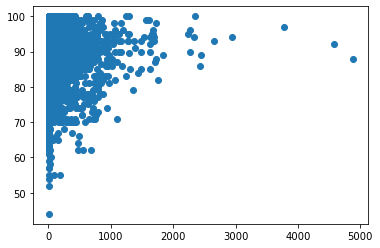

In [307]:
fig = plt.figure(1)
plt.scatter(X['num_reviews'],y)
plt.show()

## regressor

In [308]:
X_shuff, y_shuff = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_shuff, y_shuff, test_size=0.2,random_state=42)

In [309]:
def test_regressor(regressor,print_R2=True,
                   residual_hist=False,predictions_hist=False,scatter_plot=True):
    regressor.fit(X_train,y_train)
    if print_R2:
        print(f'R^2 score: {regressor.score(X_test, y_test)}')
    y_predict = regressor.predict(X_test)
    if residual_hist:
        fig = plt.figure(1)
        plt.hist(y_predict-y_test,bins=30,alpha=0.5);
        plt.show()
    if predictions_hist:
        fig = plt.figure(2)
        plt.hist(y_predict,bins=30,alpha=0.5)
        plt.hist(y_test,bins=30,alpha=0.5)
        plt.show()
    if scatter_plot:
        fig = plt.figure(3)
        plt.scatter(y_test,y_predict)

R^2 score: 0.1984466942118185
CPU times: total: 15.6 ms
Wall time: 11 ms


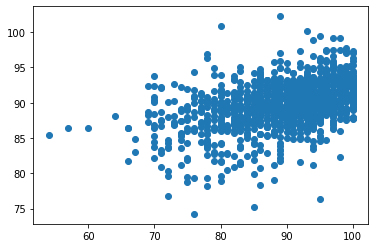

In [315]:
%%time
regressor = Ridge(alpha=10)
test_regressor(regressor)

In [314]:
%%time
parameters = {
    'alpha': [0.01,0.1,1,10]
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

CPU times: total: 31.2 ms
Wall time: 39 ms


{'alpha': 10}

R^2 score: 0.2149223841959319
CPU times: total: 1.61 s
Wall time: 478 ms


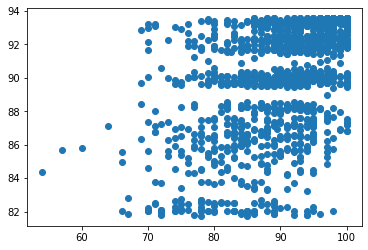

In [322]:
%%time
regressor = ensemble.RandomForestRegressor(max_depth=3, n_estimators=500,
                                           min_samples_split=2, min_samples_leaf=20,
                                           n_jobs=-1)
test_regressor(regressor)

In [323]:
%%time
parameters = {
    # 'max_depth': [2,3,4,5,6],
    # 'min_samples_split': [2,3,5,10,20],
    # 'min_samples_leaf': [2,5,10,20]
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

CPU times: total: 7.38 s
Wall time: 6.95 s


{'max_depth': 3}

R^2 score: 0.2212723413894
CPU times: total: 188 ms
Wall time: 187 ms


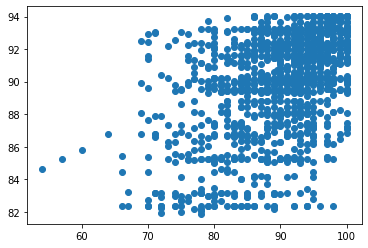

In [367]:
%%time
regressor = ensemble.GradientBoostingRegressor(max_depth=1, n_estimators=100,
                                               min_samples_split=2, min_samples_leaf=20)
test_regressor(regressor)

In [365]:
%%time
parameters = {
    # 'max_depth': [1,2,3,4,5,6],
    # 'min_samples_split': [5,15,20],
    'min_samples_leaf': [10,20,50,100]
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

CPU times: total: 828 ms
Wall time: 838 ms


{'min_samples_leaf': 20}

In [368]:
filename = agg_model_directory + 'supervised_model_GBtree.pkl'
pkl.dump(regressor, open(filename,'wb'))

## overall pipeline

In [369]:
features = {}
review_model = {}
aggregate_model = {}

In [370]:
# supervised model with tfidf + ridge
key = 'supervised'
features[key] = pkl.load(open(review_model_directory + 'supervised_features.pkl', 'rb'))
review_model[key] = pkl.load(open(review_model_directory + 'supervised_model_ridge.pkl', 'rb'))
aggregate_model[key] = pkl.load(open(agg_model_directory + 'supervised_model_GBtree.pkl', 'rb'))

In [371]:
reviews = yelp_query.get_reviews(name = "Super Bowl", address="719 W William Cannon Dr Ste 103")

Business found: Super Bowl


In [373]:
%%time
key = 'supervised'
X_out = features[key].transform(reviews)
y_predict = review_model[key].predict(X_out)

CPU times: total: 31.2 ms
Wall time: 23 ms


In [374]:
df = pd.DataFrame({})
df['predict'] = y_predict
fm = df.agg(
    Mean = ('predict', np.mean),
    Stderr = ('predict', stderr),
    Min = ('predict', np.min),
    Median = ('predict', 'median'),
    num_reviews = ('predict', 'count')
).T
fm

,Mean,Stderr,Min,Median,num_reviews
predict,85.226818,0.013073,75.930436,85.507684,222.0


In [375]:
aggregate_model[key].predict(fm)

array([82.98834138])

## final output

In [13]:
def get_cleanliness_score(reviews, key='supervised'):
    # apply individual review model
    X_out = features[key].transform(reviews)
    y_predict = review_model[key].predict(X_out)
    # build aggregate features
    df = pd.DataFrame({})
    df['predict'] = y_predict
    fm = df.agg(
        Mean = ('predict', np.mean),
        Stderr = ('predict', stderr),
        Min = ('predict', np.min),
        Median = ('predict', 'median'),
        num_reviews = ('predict', 'count')
    ).T
    # apply aggregate models
    return aggregate_model[key].predict(fm)[0]

In [28]:
reviews = yelp_query.get_reviews(name = "Super Bowl", address="719 W Cannon Blvd")
print(reviews[0])
get_cleanliness_score(reviews, 'supervised')

Business found: Super Bowl
The Super Bowl is supposed to be an exciting, fun experience for the whole family. Yet, the only similarity between the actual Super Bowl and this restaurant would be the taste of the players' jock straps. 

Okay, that may be a little gross, but I am serious when I say that Super Bowl is a bastardization of everything good about Chinese food. 

As you walk into the restaurant, you are immediately off put by the hideous decor, or lack-thereof. Insufferable faded white walls are plagued by tacky paintings while filthy, outdated tables line the floors.

It is a cafeteria style restaurant off of William Cannon, and the food is just awful. I had a orange chicken, and it was a far cry from any version of orange chicken that I have ever had. It was greasy and salty on the outside, and dry on the inside; a combination I never thought could be achieved.

The only reason this greasy spoon isn't a one star review is the staff on hand. They were very nice and attentive, 

83.3319173425126

In [29]:
reviews = yelp_query.get_reviews(name = "Kung Fu Tea", address="9070 Research Blvd")
print(reviews[0])
get_cleanliness_score(reviews, 'supervised')

Business found: Kung Fu Tea
I've been waiting for this location to open for over half a year! Imagine my excitement when I drove by a week before their grand opening and saw lights on inside! My friends and I ran out of the car, saw the opened door, and met the owners who were setting up for a private event later in the day. 

The owners, Calvin and Howard, were super friendly! Even though it was meant to be a private event for friends & family, they invited us to return later in the day to help the staff train! It also meant free boba!! The staff here in general were all very friendly as well! 

I hate to say this, but this Kung Fu has better boba and tea than the other location. The boba here is much softer and sweeter, which is closer to my preferred boba texture. I ordered the Oolong Milk tea, and I could actually taste the Oolong! At the campus one, the oolong flavor was very weak. 

The interior is very industrial chic. There are also plenty of tables and chairs for those who lik

91.6765409058971

# word vectors

Tried a variety of different things using word2vec, but found the best method was averaging ALL of the individual glove vectors of each word in each review together, and then averaging those reviews together for each BUSINESS, not each inspection. This ends with 200 features for the mean vector, plus four more features: # reviews, mean similarity to DIRTY_VECTOR, sim to PEST_VECTOR, and max(DIRTY, PEST).

Running cross validation with a few different regressors/classifiers on these features, I get an R^2 of 0.35 using a Random Forest regressor, and slightly better (0.376) using Ridge.

## using mean vectors

### import features

In [9]:
%%time
df = pd.read_csv(model_directory + 'review_model/mean_vectors_full_df.csv.gz',compression='gzip').dropna()
df = df.drop(df.columns[0],axis=1)

CPU times: total: 21.4 s
Wall time: 21.4 s


In [286]:
df.drop(['business_id', 'review_id', 'text', 'date', 'Score','stars', 'language'],axis=1).review_stars

0         5
1         5
2         5
3         5
4         5
         ..
569993    5
569994    4
569995    5
569996    5
569997    5
Name: review_stars, Length: 569995, dtype: int64

In [281]:
df.columns[8:]

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '193', '194', '195', '196', '197', '198', '199', 'both_sim', 'pest_sim',
       'dirty_sim'],
      dtype='object', length=203)

In [288]:
df.drop(drop_columns,axis=1)

,review_stars,0,1,2,3,4,5,6,7,8,...,193,194,195,196,197,198,199,both_sim,pest_sim,dirty_sim
0,5,-0.149644,-0.122643,-0.064798,0.016546,0.060250,0.031754,0.451502,-0.015059,-0.128166,...,0.015273,0.210545,0.069562,0.062164,0.130708,0.058312,-0.030418,0.338668,0.268513,0.325552
1,5,-0.220990,0.018522,-0.046335,0.075083,-0.053893,0.057965,0.433751,-0.020273,-0.006264,...,-0.049427,0.006581,-0.045144,-0.054265,0.110336,0.165070,-0.055029,0.325363,0.251382,0.321000
2,5,-0.252817,-0.001641,-0.324473,0.092807,0.034154,0.119773,0.583292,-0.144077,0.052148,...,-0.285296,0.078227,0.027386,0.003531,-0.177844,-0.102125,-0.131617,0.326433,0.268147,0.294421
3,5,-0.251347,-0.177048,-0.026470,-0.002804,0.072531,0.079423,0.424232,-0.066577,-0.093266,...,0.084801,0.156346,-0.053770,0.139058,0.087276,0.052786,0.083152,0.367837,0.282492,0.354847
4,5,-0.004754,0.008192,-0.028288,-0.012225,-0.008772,-0.004464,0.505950,-0.087937,-0.147471,...,-0.226280,0.003867,0.040343,-0.067487,-0.096109,-0.016678,-0.074489,0.385525,0.311132,0.380308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569993,5,-0.203697,-0.106234,-0.082619,0.093718,-0.024393,0.229867,0.769271,-0.056661,-0.055865,...,0.056903,0.258607,0.185722,0.045471,0.157686,0.146119,0.053863,0.435598,0.327737,0.434022
569994,4,-0.134900,-0.176433,-0.006795,0.082887,-0.084608,0.155537,0.566893,-0.067352,-0.207246,...,-0.023079,0.093424,0.015331,0.099175,0.009800,-0.123251,-0.091498,0.438623,0.305660,0.436368
569995,5,-0.390356,-0.379606,0.022955,0.214871,-0.051215,0.113260,0.586720,-0.132973,-0.101572,...,0.048325,0.129847,-0.027195,-0.079704,-0.031927,0.025438,0.119413,0.406069,0.291748,0.397331
569996,5,-0.321421,-0.153525,-0.045049,-0.004438,0.032681,0.141158,0.512632,-0.108289,-0.137008,...,0.135682,0.140226,0.026177,0.074189,0.088494,0.091305,0.055607,0.394838,0.302446,0.392174


In [303]:
%%time
drop_columns = ['business_id', 'review_id', 'text', 'date', 'Score','stars', 'language']
groups = df.sort_values('both_sim',ascending=False).groupby('business_id')
df_list = []
for business_id, group in groups:
    dff = pd.DataFrame()
    # average ALL reviews from each business
    ll = len(group)
    # bound = math.ceil(ll*0.15)
    dff[business_id] = group.drop(drop_columns,axis=1).mean(axis=0)
    dff=dff.T
    dff['num_reviews'] = ll
    # dff['percent_bad_reviews'] = sum(group.review_stars <= 2) / ll
    dff['Score'] = group.Score.unique().mean()
    df_list.append(dff)
df_tot = pd.concat(df_list)

CPU times: total: 5.58 s
Wall time: 5.59 s


### regressor cv

In [392]:
%%time
X = df_tot.drop(['Score','num_reviews','review_stars'],axis=1)
# X['thing'] = ((X.both_sim-X.both_sim.min())/(X.both_sim.max()-X.both_sim.min()))**(1)
# X=X[['thing']]
y = df_tot.Score.values

X_shuff, y_shuff = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_shuff, y_shuff, test_size=0.2, random_state=42)

CPU times: total: 0 ns
Wall time: 7 ms


R^2 score: 0.3755377368483762


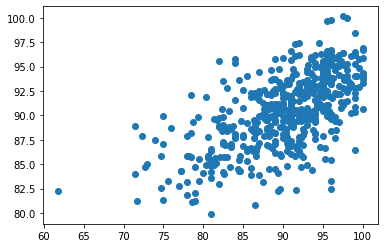

CPU times: total: 469 ms
Wall time: 85 ms


In [386]:
%%time
regressor = Ridge(alpha=0.5929292929292929)
regressor.fit(X_train,y_train)
print(f'R^2 score: {regressor.score(X_test, y_test)}')
y_predict = regressor.predict(X_test)
fig = plt.figure(3)
plt.scatter(y_test,y_predict)
plt.show()

In [274]:
filename = agg_model_directory + 'mean_vectors_agg_model_ridge.pkl'
pkl.dump(regressor, open(filename,'wb'))

R^2 score: 0.32810441256176315


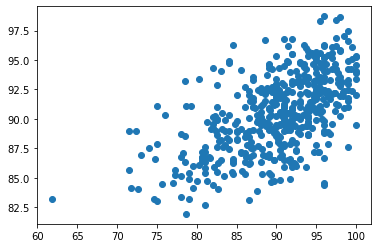

CPU times: total: 78.1 ms
Wall time: 76 ms


In [169]:
%%time
regressor = sklearn.linear_model.Lasso(alpha=0.006363636363636364,max_iter=10000, tol=0.0001)
regressor.fit(X_train,y_train)
print(f'R^2 score: {regressor.score(X_test, y_test)}')
y_predict = regressor.predict(X_test)
fig = plt.figure(3)
plt.scatter(y_test,y_predict)
plt.show()

In [272]:
%%time
parameters = {
    'alpha': np.linspace(0.5,0.6,100)
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

CPU times: total: 11.4 s
Wall time: 1.91 s


{'alpha': 0.5929292929292929}

R^2 score: 0.3426341240025177


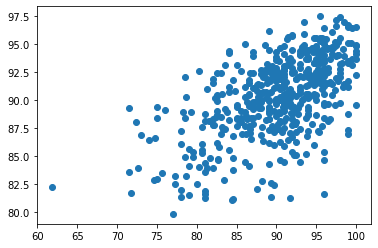

CPU times: total: 3min 10s
Wall time: 16.4 s


In [393]:
%%time
regressor = ensemble.RandomForestRegressor(max_depth=20, n_estimators=1000,# max_features=20,
                                           min_samples_split=10, min_samples_leaf=2,
                                           n_jobs=-1)
regressor.fit(X_train,y_train)
print(f'R^2 score: {regressor.score(X_test, y_test)}')
y_predict = regressor.predict(X_test)
fig = plt.figure(3)
plt.scatter(y_test,y_predict)
plt.show()

R^2 score: 0.8532194586798937


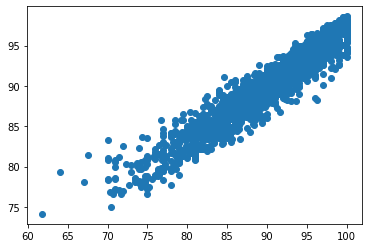

CPU times: total: 4min 9s
Wall time: 21.3 s


In [394]:
%%time
regressor = ensemble.RandomForestRegressor(max_depth=20, n_estimators=1000,# max_features=20,
                                           min_samples_split=10, min_samples_leaf=2,
                                           n_jobs=-1)
regressor.fit(X,y)
print(f'R^2 score: {regressor.score(X, y)}')
y_predict = regressor.predict(X)
fig = plt.figure(3)
plt.scatter(y,y_predict)
plt.show()

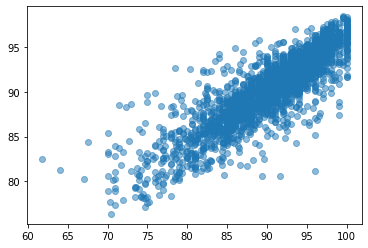

In [370]:
y_predict = regressor.predict(X)
plt.scatter(y,y_predict,alpha=0.5)
plt.show()

In [395]:
filename = agg_model_directory + 'mean_vectors_agg_model.pkl'
pkl.dump(regressor, open(filename,'wb'))

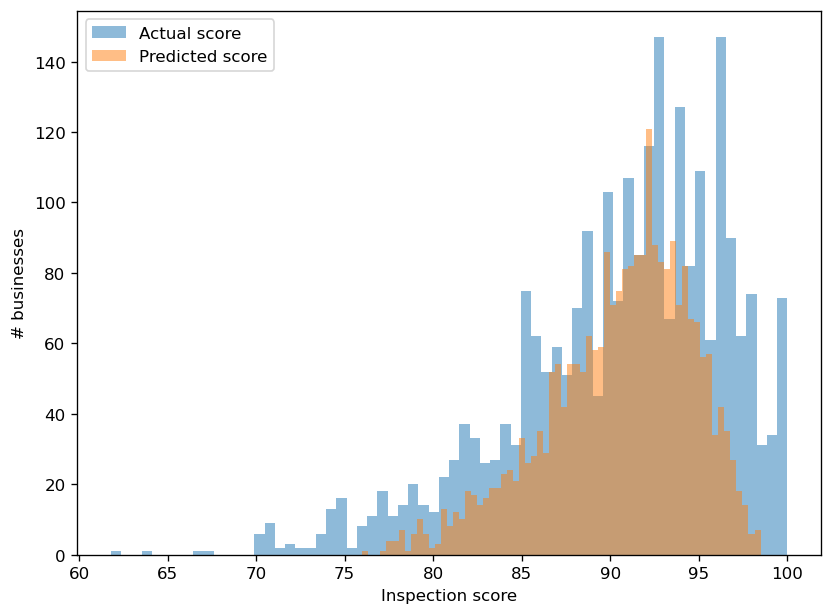

In [325]:
y_predict = regressor.predict(X)
fig = plt.figure(figsize=(8,6),dpi=120)
plt.hist(y,bins=66,alpha=0.5)
plt.hist(y_predict,bins=66,alpha=0.5)
plt.xlabel('Inspection score')
plt.ylabel('# businesses')
plt.legend(['Actual score','Predicted score'])
plt.show()

In [378]:
%%time
parameters = {
    # 'max_depth': [10,15,20],
    # 'min_samples_split': [2,5,10],
    # 'min_samples_leaf': [2,5,10],
    'max_features':range(15,25)
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

CPU times: total: 9.56 s
Wall time: 8.8 s


{'max_features': 20}

R^2 score: 0.28507629264654333


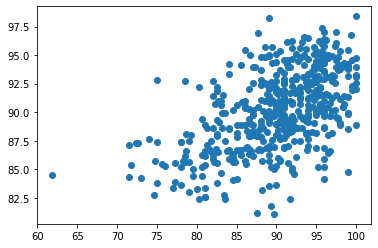

CPU times: total: 24.8 s
Wall time: 24.8 s


In [283]:
%%time
regressor = ensemble.GradientBoostingRegressor(max_depth=1, n_estimators=1000,
                                               min_samples_split=2, min_samples_leaf=15)
regressor.fit(X_train,y_train)
print(f'R^2 score: {regressor.score(X_test, y_test)}')
y_predict = regressor.predict(X_test)
fig = plt.figure(3)
plt.scatter(y_test,y_predict)
plt.show()

In [282]:
%%time
parameters = {
    # 'max_depth': np.arange(1,5,1),
    # 'min_samples_split': [2,5,10,15,20,25,30],
    'min_samples_leaf': [2,5,10,15,20]
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

CPU times: total: 10.8 s
Wall time: 10.8 s


{'min_samples_leaf': 15}

# old stuff

## pre-trained glove on EACH review, agg over each business

In [417]:
df_test = pd.read_csv(model_directory + 'review_model/top5percent_per_review.csv').dropna()

In [379]:
df_test = df_test[df_test.review_stars <= 2]

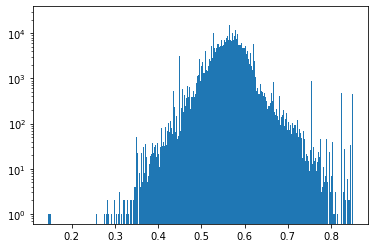

In [419]:
# all of the scores...
# many of the lowest scores are not in English.
plt.hist(df_test.predict,bins=500)
# plt.ylim(0,10000)
plt.yscale('log')
plt.show()

In [420]:
np.mean(df_test.predict)

0.5632534097087785

In [421]:
# apply discriminator to get percentage of reviews which directly talk about dirtiness
def discriminator(predictions, threshold = 0.6):
    return sum(predictions > threshold)/len(predictions)

In [422]:
df_test['text_length'] = df_test.text.apply(len)

In [423]:
# individual inspections
overall_median = np.median(df_test.predict)
features = df_test.dropna().groupby('business_id').agg(
    Score = ('Score', np.min),
    stars_mean = ('review_stars', np.mean),
    stars_stdev = ('review_stars', np.std),
    stars_stderr = ('review_stars', lambda x: np.std(x)/len(x)),
    review_length_mean = ('text_length', np.mean),
    review_length_stdev = ('text_length', np.std),
    glove_mean = ('predict', np.mean),
    glove_max = ('predict', np.max),
    glove_stdev = ('predict', np.std),
    glove_stderr = ('predict', lambda x: np.std(x)/len(x)),
    # glove_2ndmax = ('predict', lambda x: np.mean(sorted(x)[-2])),
    # glove_3rdmax = ('predict', lambda x: np.mean(sorted(x)[-3])),
    glove_min = ('predict', np.min),
    # glove_2ndmin = ('predict', lambda x: np.mean(sorted(x)[2])),
    glove_1stquantile = ('predict', lambda x: np.quantile(x,0.25)),
    glove_3rdquantile = ('predict', lambda x: np.quantile(x,0.75)),
    glove_1percent = ('predict', lambda x: np.mean(sorted(x)[-math.ceil(len(x)*0.01):])),
    glove_5percent = ('predict', lambda x: np.mean(sorted(x)[-math.ceil(len(x)*0.05):])),
    glove_25percent = ('predict', lambda x: np.mean(sorted(x)[-math.ceil(len(x)*0.25):])),
    glove_discrim_median = ('predict', lambda x: discriminator(x,overall_median)),
    glove_discrim_6 = ('predict', lambda x: discriminator(x,0.6)),
    glove_discrim_7 = ('predict', lambda x: discriminator(x,0.7)),
    num_reviews = ('predict',len)
).reset_index().dropna()

In [424]:
features

,business_id,Score,stars_mean,stars_stdev,stars_stderr,review_length_mean,review_length_stdev,glove_mean,glove_max,glove_stdev,...,glove_min,glove_1stquantile,glove_3rdquantile,glove_1percent,glove_5percent,glove_25percent,glove_discrim_median,glove_discrim_6,glove_discrim_7,num_reviews
0,-0TbQsmE2p1bhG30rgvK2Q,93.0,3.881720,1.458479,0.015598,489.795699,438.618398,0.552508,0.665917,0.040836,...,0.422774,0.529923,0.579391,0.665917,0.638217,0.600703,0.397849,0.096774,0.000000,93
1,-4bP1UUgpZumIu6DZMaMzw,86.0,4.046931,1.141665,0.002059,574.095668,525.703655,0.560573,0.755413,0.037480,...,0.404551,0.541263,0.581013,0.683500,0.639060,0.601604,0.500000,0.090253,0.001805,554
2,-4cQ12xutjNLW-tPI06_tg,88.0,3.604651,1.399824,0.016182,560.953488,495.717019,0.565158,0.664877,0.040931,...,0.433693,0.540345,0.589212,0.664877,0.638817,0.614081,0.534884,0.197674,0.000000,86
3,-4ofMtrD7pSpZIX5pnDkig,79.0,3.980286,1.132221,0.000769,525.397009,448.593692,0.556863,0.849937,0.042083,...,0.337684,0.534355,0.578256,0.737476,0.657015,0.604329,0.448674,0.089055,0.008838,1471
4,-6obgh8LkS9L0Ww1zHdTNg,70.0,4.470588,0.717430,0.040942,609.058824,592.097381,0.557673,0.623611,0.038083,...,0.483129,0.527886,0.583623,0.623611,0.623611,0.601520,0.470588,0.176471,0.000000,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501,zlPKCqb9sfkhIW27sAGsIA,93.0,3.740385,1.238502,0.011851,542.307692,648.372257,0.561962,0.698346,0.043614,...,0.425711,0.535624,0.584616,0.683181,0.651520,0.615014,0.528846,0.163462,0.000000,104
2502,zo-POOSRX0wiVJlJyvujyA,100.0,4.268293,1.245480,0.030005,622.097561,421.353818,0.542188,0.644169,0.040266,...,0.448009,0.515426,0.565373,0.644169,0.620135,0.588214,0.268293,0.048780,0.000000,41
2503,zr40jIjFDIcZ3dzbSK53Ww,84.0,3.754386,1.502572,0.013123,471.403509,366.164398,0.567160,0.838737,0.047999,...,0.424658,0.539528,0.589220,0.753205,0.682373,0.620956,0.587719,0.166667,0.008772,114
2504,zubXuwlAEbvZd-MiLOgofQ,100.0,4.417143,0.984210,0.005608,507.817143,431.309768,0.548890,0.838737,0.050577,...,0.448009,0.523588,0.575062,0.831112,0.683811,0.605427,0.348571,0.068571,0.022857,175


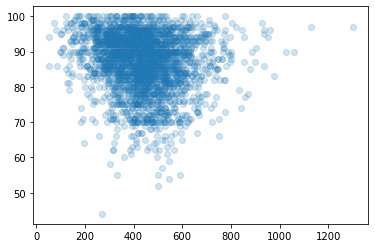

In [425]:
plt.scatter(features.review_length_stdev, features.Score,alpha=0.2)

In [426]:
def test_regressor(regressor,print_R2=True,
                   residual_hist=False,predictions_hist=False,scatter_plot=True):
    regressor.fit(X_train,y_train)
    if print_R2:
        print(f'R^2 score: {regressor.score(X_test, y_test)}')
    y_predict = regressor.predict(X_test)
    if residual_hist:
        fig = plt.figure(1)
        plt.hist(y_predict-y_test,bins=30,alpha=0.5);
        plt.show()
    if predictions_hist:
        fig = plt.figure(2)
        plt.hist(y_predict,bins=30,alpha=0.5)
        plt.hist(y_test,bins=30,alpha=0.5)
        plt.show()
    if scatter_plot:
        fig = plt.figure(3)
        plt.scatter(y_test,y_predict)

In [427]:
# %%time
# regressor = Ridge(alpha=1)
# test_regressor(regressor)

In [428]:
%%time
X = features.drop(['business_id','Score'],axis=1)
# X = features[['glove_discrim_median','num_reviews','stars_mean','glove_max']]
y = features['Score']

X_shuff, y_shuff = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_shuff, y_shuff, test_size=0.2, random_state=42)

CPU times: total: 15.6 ms
Wall time: 3 ms


R^2 score: 0.1388687192435467


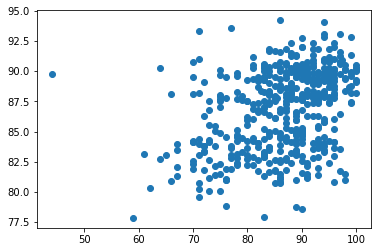

In [431]:
regressor = ensemble.RandomForestRegressor(max_depth=5, n_estimators=500,
                                           min_samples_split=5, min_samples_leaf=20,
                                           n_jobs=-1)
regressor.fit(X_train,y_train)
print(f'R^2 score: {regressor.score(X_test, y_test)}')
y_predict = regressor.predict(X_test)
fig = plt.figure(3)
plt.scatter(y_test,y_predict)
plt.show()

In [430]:
%%time
parameters = {
    'max_depth': [4,5,6],
    'min_samples_split': [2,3,5],
    'min_samples_leaf': [19,20,21]
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

CPU times: total: 36.4 s
Wall time: 37.2 s


{'max_depth': 5, 'min_samples_leaf': 21, 'min_samples_split': 5}

R^2 score: 0.12221279985177325


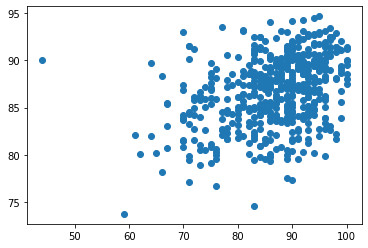

CPU times: total: 906 ms
Wall time: 899 ms


In [432]:
%%time
# train regressor on full dataset
regressor = ensemble.GradientBoostingRegressor(max_depth=2, n_estimators=200,
                                               min_samples_split=5, min_samples_leaf=60)
regressor.fit(X_train,y_train)
print(f'R^2 score: {regressor.score(X_test, y_test)}')
y_predict = regressor.predict(X_test)
fig = plt.figure(3)
plt.scatter(y_test,y_predict)
plt.show()

In [433]:
%%time
parameters = {
    'max_depth': [2,3,4,5],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [40,50,60]
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

CPU times: total: 35.9 s
Wall time: 35.9 s


{'max_depth': 2, 'min_samples_leaf': 60, 'min_samples_split': 2}

## using mean vector of dirtiest 15% words

### import and cross validate

In [14]:
%%time
df = pd.read_csv(model_directory + 'review_model/15percent_vectors_full_df.csv.gz',compression='gzip').dropna()

CPU times: total: 22.5 s
Wall time: 22.5 s


In [27]:
df.columns

Index(['business_id', 'review_id', 'text', 'date', 'review_stars', 'Score',
       'stars', 'language', '0', '1',
       ...
       '193', '194', '195', '196', '197', '198', '199', 'both_sim', 'pest_sim',
       'dirty_sim'],
      dtype='object', length=211)

In [244]:
groups = df.sort_values('both_sim',ascending=False).groupby('business_id')

In [245]:
%%time
df_list = []
for business_id, group in groups:
    dff = pd.DataFrame()
    # average ALL reviews from each business
    ll = len(group)
    # bound = math.ceil(ll*1.0)
    dff[business_id] = group[df.columns[8:]].mean(axis=0)
    dff=dff.T
    dff['num_reviews'] = ll
    dff['Score'] = group.Score.unique().mean()
    df_list.append(dff)

CPU times: total: 4.02 s
Wall time: 4.05 s


In [246]:
df_tot = pd.concat(df_list)
df_tot

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,both_sim,pest_sim,dirty_sim,num_reviews,Score
-0TbQsmE2p1bhG30rgvK2Q,-0.086969,-0.096273,-0.041944,0.157228,-0.137185,0.189924,0.759017,-0.066442,-0.217519,-0.108023,...,-0.070024,-0.057137,0.114886,-0.104393,-0.031887,0.521900,0.374044,0.519911,93,95.333333
-4bP1UUgpZumIu6DZMaMzw,-0.062950,-0.061911,-0.036384,0.165578,-0.165717,0.184858,0.773855,-0.098182,-0.186964,-0.073083,...,-0.065087,-0.018947,0.086973,-0.120612,-0.034870,0.528020,0.368792,0.527125,554,90.500000
-4cQ12xutjNLW-tPI06_tg,-0.142560,-0.096870,-0.031187,0.214549,-0.140778,0.219187,0.788852,-0.042633,-0.190838,-0.080737,...,-0.062328,-0.056190,0.100655,-0.105705,0.013669,0.534781,0.369401,0.534237,86,93.400000
-4ofMtrD7pSpZIX5pnDkig,-0.053000,-0.081516,-0.027891,0.141697,-0.105067,0.195082,0.731226,-0.089610,-0.198308,-0.085706,...,-0.046996,-0.010008,0.073353,-0.107109,-0.019602,0.525765,0.371194,0.523566,1471,85.000000
-6obgh8LkS9L0Ww1zHdTNg,-0.407696,-0.221712,-0.057810,0.188548,-0.117151,0.215167,0.787855,-0.053834,-0.202509,-0.236637,...,-0.057839,0.007619,0.132608,-0.043778,0.064850,0.527475,0.370489,0.527345,17,82.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zlPKCqb9sfkhIW27sAGsIA,-0.043690,-0.037360,-0.019857,0.130351,-0.169593,0.218525,0.765205,-0.077350,-0.183636,-0.092981,...,-0.065235,-0.012338,0.092845,-0.136875,-0.054829,0.529641,0.372383,0.528875,104,93.000000
zo-POOSRX0wiVJlJyvujyA,0.013921,0.020264,-0.047838,0.140615,-0.084517,0.201258,0.784634,-0.047280,-0.119917,-0.016841,...,-0.040482,-0.032920,0.100669,-0.083300,-0.048943,0.505263,0.369002,0.503876,41,100.000000
zr40jIjFDIcZ3dzbSK53Ww,-0.356138,-0.258914,-0.032626,0.090282,-0.091228,0.188938,0.822433,-0.015445,-0.146831,-0.217056,...,-0.104437,-0.068619,0.200632,-0.036633,0.118760,0.534063,0.369057,0.532713,114,88.500000
zubXuwlAEbvZd-MiLOgofQ,-0.114892,-0.117236,-0.025699,0.184582,-0.121042,0.213245,0.747978,-0.098817,-0.235246,-0.111695,...,-0.045445,0.005821,0.090301,-0.116756,-0.052040,0.518075,0.369964,0.515531,175,100.000000


In [247]:
def test_regressor(regressor,print_R2=True,
                   residual_hist=False,predictions_hist=False,scatter_plot=True):
    regressor.fit(X_train,y_train)
    if print_R2:
        print(f'R^2 score: {regressor.score(X_test, y_test)}')
    y_predict = regressor.predict(X_test)
    if residual_hist:
        fig = plt.figure(1)
        plt.hist(y_predict-y_test,bins=30,alpha=0.5);
        plt.show()
    if predictions_hist:
        fig = plt.figure(2)
        plt.hist(y_predict,bins=30,alpha=0.5)
        plt.hist(y_test,bins=30,alpha=0.5)
        plt.show()
    if scatter_plot:
        fig = plt.figure(3)
        plt.scatter(y_test,y_predict)

In [248]:
%%time
X = df_tot.drop('Score',axis=1)
y = df_tot.Score.values

X_shuff, y_shuff = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_shuff, y_shuff, test_size=0.2, random_state=42)

CPU times: total: 31.2 ms
Wall time: 7 ms


R^2 score: 0.252632847640453


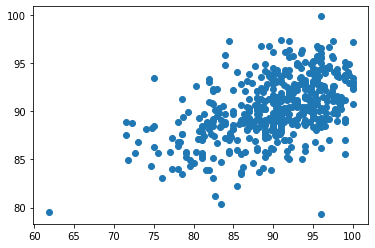

CPU times: total: 469 ms
Wall time: 72 ms


In [255]:
%%time
regressor = Ridge(alpha=0.7847599703514611)
regressor.fit(X_train,y_train)
print(f'R^2 score: {regressor.score(X_test, y_test)}')
y_predict = regressor.predict(X_test)
fig = plt.figure(3)
plt.scatter(y_test,y_predict)
plt.show()

In [254]:
%%time
parameters = {
    'alpha': np.logspace(-2,1,20)
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

CPU times: total: 2.62 s
Wall time: 431 ms


{'alpha': 0.7847599703514611}

R^2 score: 0.3190530384366882


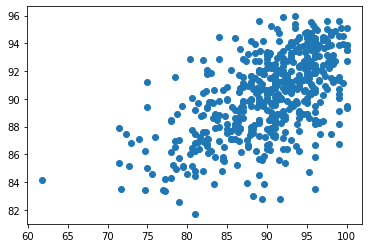

CPU times: total: 3min 8s
Wall time: 16.4 s


In [ ]:
%%time
regressor = ensemble.RandomForestRegressor(max_depth=20, n_estimators=1000,
                                           min_samples_split=5, min_samples_leaf=2,
                                           n_jobs=-1)
regressor.fit(X_train,y_train)
print(f'R^2 score: {regressor.score(X_test, y_test)}')
y_predict = regressor.predict(X_test)
fig = plt.figure(3)
plt.scatter(y_test,y_predict)
plt.show()

In [274]:
%%time
parameters = {
    'max_depth': [18,20,22,25,30],
    'min_samples_split': [2,5,10,20],
    'min_samples_leaf': [2,5,10,20]
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

CPU times: total: 38.2 s
Wall time: 1min 7s


{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}

R^2 score: 0.28507629264654333


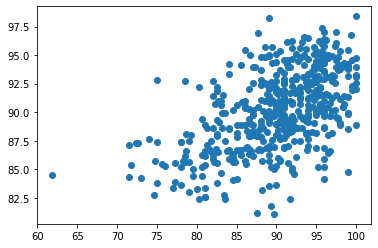

CPU times: total: 24.8 s
Wall time: 24.8 s


In [283]:
%%time
regressor = ensemble.GradientBoostingRegressor(max_depth=1, n_estimators=1000,
                                               min_samples_split=2, min_samples_leaf=15)
regressor.fit(X_train,y_train)
print(f'R^2 score: {regressor.score(X_test, y_test)}')
y_predict = regressor.predict(X_test)
fig = plt.figure(3)
plt.scatter(y_test,y_predict)
plt.show()

In [282]:
%%time
parameters = {
    # 'max_depth': np.arange(1,5,1),
    # 'min_samples_split': [2,5,10,15,20,25,30],
    'min_samples_leaf': [2,5,10,15,20]
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

CPU times: total: 10.8 s
Wall time: 10.8 s


{'min_samples_leaf': 15}

### final regressor

In [328]:
%%time
df = pd.read_csv(model_directory + 'review_model/15percent_vectors_full_df.csv.gz',compression='gzip').dropna()

CPU times: total: 28.7 s
Wall time: 28.7 s


In [329]:
%%time
groups = df.sort_values('both_sim',ascending=False).groupby('business_id')
df_list = []
for business_id, group in groups:
    dff = pd.DataFrame()
    # average ALL reviews from each business
    ll = len(group)
    # bound = math.ceil(ll*1.0)
    dff[business_id] = group[df.columns[8:]].mean(axis=0)
    dff=dff.T
    dff['num_reviews'] = ll
    dff['Score'] = group.Score.unique().mean()
    df_list.append(dff)
df_tot = pd.concat(df_list)

CPU times: total: 5.34 s
Wall time: 5.34 s


In [330]:
%%time
X = df_tot.drop('Score',axis=1)
y = df_tot.Score.values

X_shuff, y_shuff = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_shuff, y_shuff, test_size=0.2, random_state=42)

CPU times: total: 109 ms
Wall time: 107 ms


R^2 score: 0.3155605941169972


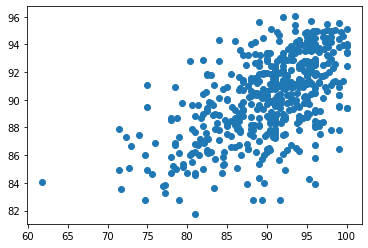

CPU times: total: 3min 8s
Wall time: 16.4 s


In [331]:
%%time
regressor = ensemble.RandomForestRegressor(max_depth=20, n_estimators=1000,
                                           min_samples_split=5, min_samples_leaf=2,
                                           n_jobs=-1)
regressor.fit(X_train,y_train)
print(f'R^2 score: {regressor.score(X_test, y_test)}')
y_predict = regressor.predict(X_test)
fig = plt.figure(3)
plt.scatter(y_test,y_predict)
plt.show()

In [332]:
# export regressor
filename = agg_model_directory + '15percent_vectors_agg_model.pkl'
pkl.dump(regressor, open(filename,'wb'))

### try grouping by inspection, not business -- this sucks

In [ ]:
%%time
df = pd.read_csv(model_directory + 'review_model/15percent_vectors_full_df.csv.gz',compression='gzip').dropna()

CPU times: total: 22.5 s
Wall time: 22.5 s


In [ ]:
%%time
groups = df.sort_values('both_sim',ascending=False).groupby(['business_id','Score'])
df_list = []
for business_id, group in groups:
    dff = pd.DataFrame()
    # average ALL reviews from each business
    ll = len(group)
    # bound = math.ceil(ll*1.0)
    dff[business_id] = group[df.columns[8:]].mean(axis=0)
    dff=dff.T
    dff['num_reviews'] = ll
    dff['Score'] = group.Score.unique().mean()
    df_list.append(dff)
df_tot = pd.concat(df_list)

CPU times: total: 9.22 s
Wall time: 9.25 s


In [ ]:
%%time
X = df_tot.drop('Score',axis=1)
y = df_tot.Score.values

X_shuff, y_shuff = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_shuff, y_shuff, test_size=0.2, random_state=42)

CPU times: total: 15.6 ms
Wall time: 23 ms


R^2 score: 0.11886921591839616


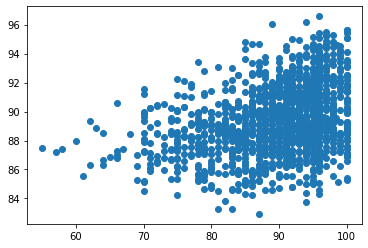

CPU times: total: 9min 45s
Wall time: 49.9 s


In [ ]:
%%time
regressor = ensemble.RandomForestRegressor(max_depth=20, n_estimators=1000,
                                           min_samples_split=5, min_samples_leaf=2,
                                           n_jobs=-1)
regressor.fit(X_train,y_train)
print(f'R^2 score: {regressor.score(X_test, y_test)}')
y_predict = regressor.predict(X_test)
fig = plt.figure(3)
plt.scatter(y_test,y_predict)
plt.show()

## using mean vectors to predict individual reviews -- this sucks

In [ ]:
%%time
df = pd.read_csv(model_directory + 'review_model/mean_vectors_full_df.csv.gz',compression='gzip').dropna().drop(df.columns[0],axis=1)

CPU times: total: 25.6 s
Wall time: 25.6 s


In [ ]:
%%time
X = df[df.columns[8:]]
y = df.Score.values

X_shuff, y_shuff = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_shuff, y_shuff, test_size=0.2, random_state=42)

CPU times: total: 1.56 s
Wall time: 1.56 s


R^2 score: 0.09128650996688781


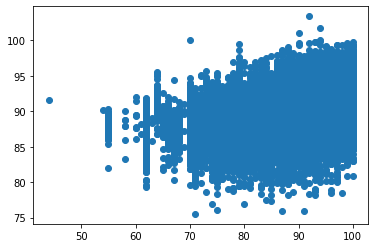

CPU times: total: 4.02 s
Wall time: 1.15 s


In [ ]:
%%time
regressor = Ridge(alpha=0.02069138081114788)
regressor.fit(X_train,y_train)
print(f'R^2 score: {regressor.score(X_test, y_test)}')
y_predict = regressor.predict(X_test)
fig = plt.figure(3)
plt.scatter(y_test,y_predict)
plt.show()

In [ ]:
%%time
parameters = {
    'alpha': np.logspace(-5,2,20)
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

CPU times: total: 2min 14s
Wall time: 22.6 s


{'alpha': 0.02069138081114788}

R^2 score: 0.04761528737273091


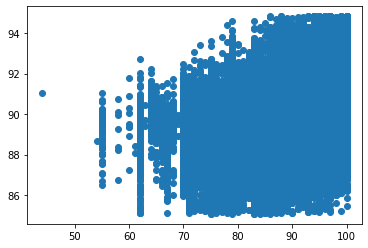

CPU times: total: 1h 16min 54s
Wall time: 6min 55s


In [ ]:
%%time
regressor = ensemble.RandomForestRegressor(max_depth=5, n_estimators=100,
                                           min_samples_split=10, min_samples_leaf=5,
                                           n_jobs=-1)
regressor.fit(X_train,y_train)
print(f'R^2 score: {regressor.score(X_test, y_test)}')
y_predict = regressor.predict(X_test)
fig = plt.figure(3)
plt.scatter(y_test,y_predict)
plt.show()

In [ ]:
%%time
parameters = {
    'max_depth': [22,25,27],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [2,5,10]
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

CPU times: total: 53.9 s
Wall time: 2min 2s


{'max_depth': 25, 'min_samples_leaf': 5, 'min_samples_split': 10}

## try classification

In [33]:
def myround(x, base=5):
    return base * round(x/base)
round_ndarray = np.vectorize(myround)

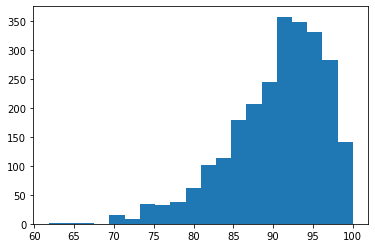

In [164]:
plt.hist(df_tot.Score.values,bins=20)
plt.show()

In [79]:
df_tot.Score.median()

91.5

In [83]:
(df_tot.Score < df_tot.Score.median()).astype(int)

-0TbQsmE2p1bhG30rgvK2Q    0
-4bP1UUgpZumIu6DZMaMzw    1
-4cQ12xutjNLW-tPI06_tg    0
-4ofMtrD7pSpZIX5pnDkig    1
-6obgh8LkS9L0Ww1zHdTNg    1
                         ..
zlPKCqb9sfkhIW27sAGsIA    0
zo-POOSRX0wiVJlJyvujyA    0
zr40jIjFDIcZ3dzbSK53Ww    1
zubXuwlAEbvZd-MiLOgofQ    0
zvSUJ7J2-GcB-2E0W2ICbw    0
Name: Score, Length: 2506, dtype: int32

In [112]:
%%time
X = df_tot.drop('Score',axis=1)
y = (df_tot.Score < 85).astype(int).values

X_shuff, y_shuff = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_shuff, y_shuff, test_size=0.2, random_state=42)

CPU times: total: 0 ns
Wall time: 7 ms


Accuracy: 0.8286852589641435


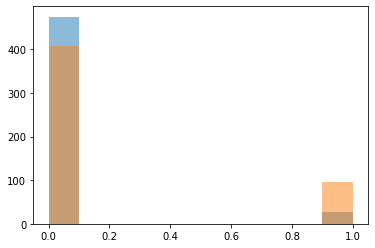

CPU times: total: 1min 1s
Wall time: 8.31 s


In [146]:
%%time
classifier = ensemble.RandomForestClassifier(max_depth=10, n_estimators=5000,
                                             min_samples_split=2, min_samples_leaf=2,
                                             n_jobs=-1)
classifier.fit(X_train,y_train)
print(f'Accuracy: {classifier.score(X_test, y_test)}')
y_predict = classifier.predict(X_test)
plt.hist(y_predict,alpha=0.5)
plt.hist(y_test,alpha=0.5)
plt.show()

In [124]:
%%time
parameters = {
    'max_depth': [1,2,3,4,5]
    # 'min_samples_split': [2,5,10,15,20],
    # 'min_samples_leaf': [2,5,10,15,20]
}
gs = GridSearchCV(classifier, parameters)
gs.fit(X_test,y_test)
gs.best_params_

CPU times: total: 14.4 s
Wall time: 12.5 s


{'max_depth': 5}

Accuracy: 0.8107569721115537


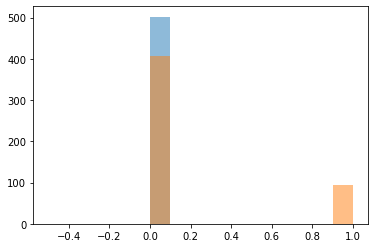

CPU times: total: 93.8 ms
Wall time: 90 ms


In [142]:
%%time
classifier = sklearn.linear_model.SGDClassifier(alpha=0.000026)
classifier.fit(X_train,y_train)
print(f'Accuracy: {classifier.score(X_test, y_test)}')
y_predict = classifier.predict(X_test)
plt.hist(y_predict,alpha=0.5)
plt.hist(y_test,alpha=0.5)
plt.show()

In [105]:
%%time
parameters = {
    'alpha': [0.001,0.01,0.1,1,10]
}
gs = GridSearchCV(classifier, parameters)
gs.fit(X_test,y_test)
gs.best_params_

CPU times: total: 141 ms
Wall time: 150 ms


{'alpha': 10}

Accuracy: 0.8247011952191236


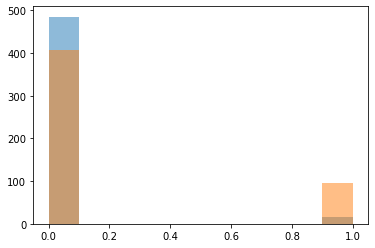

CPU times: total: 109 ms
Wall time: 102 ms


In [143]:
%%time
classifier = sklearn.linear_model.LogisticRegression(solver='lbfgs',penalty='l2',tol=0.001,max_iter=2000)
classifier.fit(X_train,y_train)
print(f'Accuracy: {classifier.score(X_test, y_test)}')
y_predict = classifier.predict(X_test)
plt.hist(y_predict,alpha=0.5)
plt.hist(y_test,alpha=0.5)
plt.show()

## scratch work

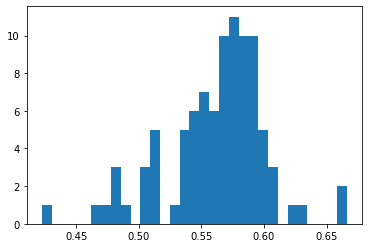

In [1005]:
for key, group in df_test.dropna().groupby('business_id'):
    plt.hist(group.predict,bins=math.ceil(len(group)/3))
    break

In [1019]:
test = df_test.dropna().groupby('business_id')
all_keys = list(test.groups.keys())

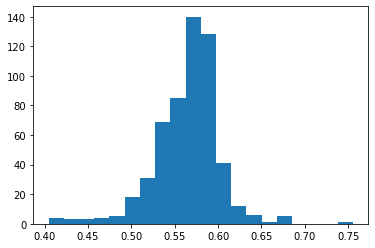

In [1018]:
idx = 1
plt.hist(df_test.dropna()[df_test.dropna().business_id == this_key].predict, bins = 20)
plt.show()

In [1055]:
# look at dirtiness score histograms for each business
from ipywidgets import interact, IntSlider

test = df_test.dropna().groupby('business_id')
all_keys = list(test.groups.keys())
def plot_hists(index):
    this_key = all_keys[index]
    fig = plt.figure()
    plt.hist(df_test.dropna()[df_test.dropna().business_id == this_key].predict, bins = 20)
    plt.title(this_key)
    plt.xlim(0.4,0.7)

interact(plot_hists, index=IntSlider(min=0, max=len(all_keys), step=1, value=1, description='INDEX'))

interactive(children=(IntSlider(value=1, description='INDEX', max=2506), Output()), _dom_classes=('widget-inte…

<function __main__.plot_hists(index)>

(0.5, 0.8)

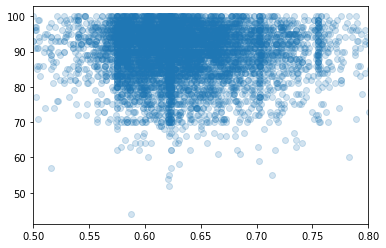

In [928]:
# individual inspections
display_df = df_test.dropna().groupby(['business_id','Score']).agg(
    glove_mean = ('predict', np.mean),
    glove_max = ('predict', np.max),
    glove_5percent = ('predict', lambda x: np.mean(sorted(x)[-math.ceil(len(x)*0.05):])),
    glove_25percent = ('predict', lambda x: np.mean(sorted(x)[-math.ceil(len(x)*0.25):])),
    LEN = ('predict',len)
).reset_index()
# new_df
plt.scatter(display_df.P_5percent, display_df.Score,alpha=0.2)
plt.xlim(0.5,0.8)

In [929]:
display_df

,business_id,Score,P_mean,P_max,P_5percent,P_25percent,LEN
0,-0TbQsmE2p1bhG30rgvK2Q,93.0,0.561869,0.665917,0.638940,0.604406,91
1,-0TbQsmE2p1bhG30rgvK2Q,95.0,0.554819,0.554819,0.554819,0.554819,1
2,-0TbQsmE2p1bhG30rgvK2Q,98.0,0.587358,0.587358,0.587358,0.587358,1
3,-4bP1UUgpZumIu6DZMaMzw,86.0,0.564605,0.755413,0.638698,0.603939,551
4,-4bP1UUgpZumIu6DZMaMzw,95.0,0.546350,0.578693,0.578693,0.575395,5
...,...,...,...,...,...,...,...
6612,zo-POOSRX0wiVJlJyvujyA,100.0,0.550204,0.644169,0.623998,0.594160,41
6613,zr40jIjFDIcZ3dzbSK53Ww,84.0,0.570818,0.603337,0.603337,0.595796,15
6614,zr40jIjFDIcZ3dzbSK53Ww,93.0,0.576151,0.706883,0.663887,0.620880,99
6615,zubXuwlAEbvZd-MiLOgofQ,100.0,0.554177,0.838737,0.683811,0.608397,175


(array([1.815e+03, 3.230e+02, 1.100e+02, 5.100e+01, 1.500e+01, 1.300e+01,
        8.000e+00, 5.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 1.  ,  5.85, 10.7 , 15.55, 20.4 , 25.25, 30.1 , 34.95, 39.8 ,
        44.65, 49.5 , 54.35, 59.2 , 64.05, 68.9 , 73.75, 78.6 , 83.45,
        88.3 , 93.15, 98.  ]),
 <BarContainer object of 20 artists>)

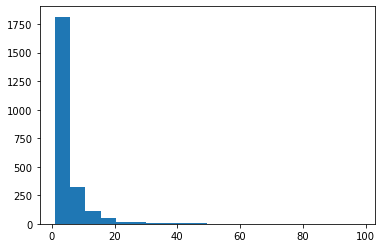

In [922]:
plt.hist(df_test.groupby(['business_id','Score']).text.agg(len),bins=20)

In [880]:
new_df[new_df.LEN < 5]

,business_id,Score,P_mean,P_max,P_5percent,LEN
6,41kwNkIJMsK_flnEqy5YIQ,99.0,0.576753,0.606792,0.606792,4
8,5Kklp6a7lggH2XQ2MSYANA,83.0,0.520277,0.520277,0.520277,1
9,5Kklp6a7lggH2XQ2MSYANA,90.0,0.588253,0.618178,0.618178,4
11,5N4bHv9sTm1JsDqhDWz-tA,88.0,0.585898,0.585898,0.585898,1
12,5N4bHv9sTm1JsDqhDWz-tA,90.0,0.585409,0.598894,0.598894,3
22,FXs03HmN_vW8axbAB7lG1w,91.0,0.316157,0.567058,0.567058,3
23,FXs03HmN_vW8axbAB7lG1w,95.0,0.521892,0.534170,0.534170,2
25,GrnS4hEW6smYaIe_KzDOWw,83.0,0.575028,0.575028,0.575028,1
26,HJisBzwgGpCZu0ZkO8LFzA,59.0,0.585344,0.702068,0.702068,4
34,KEh3efWSOIzd8BvuW-X4-g,83.0,0.589768,0.600710,0.600710,3


In [863]:
new_df.groupby(['business_id','Score']).agg(
    Score = ('Score', np.mean),
    P_mean = ('predict', np.mean),
    P_max = ('predict', np.max)
).reset_index()

ValueError: cannot insert Score, already exists

In [852]:
new_df = df.copy().loc[12000:20000]
new_df['predict'] = dirty_scores

ValueError: Length of values (8000) does not match length of index (8001)

In [853]:
len(dirty_scores)

8000

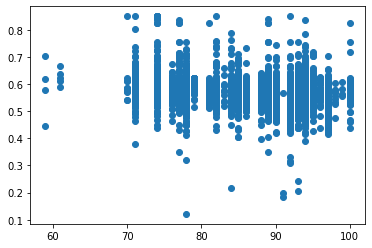

In [850]:
plt.scatter(df.Score[12000:20000],dirty_scores)

In [834]:
dirty_scores

array([0.5778080821037292, 0.5801986157894135, 0.6203206181526184, ...,
       0.5806902050971985, 0.5500458776950836, 0.6269631385803223],
      dtype=object)

In [ ]:
pd.isnull(df).any(1).nonzero()[0]



In [847]:
df.loc[12812]

business_id                                bZiIIUcpgxh8mpKMDhdqbA
review_id                                  DOLa_QilayjG6mXr6FZtzA
text            ここのバーガーはとても美味し買った。ハンバーガーを注文する際に、スタッフが座席を指定してくれ...
date                                          2019-03-17 03:18:35
review_stars                                                    5
Score                                                        92.0
stars                                                         4.0
Name: 12812, dtype: object

In [846]:
pd.isnull(dirty_scores).nonzero()

(array([812], dtype=int64),)

In [682]:
np.argmax(dirty_scores)

1424

(array([  1.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,   1.,   1.,   1.,
          2.,   0.,   2.,   3.,   3.,   7.,  27.,  15.,  50.,  38.,  27.,
         24.,  65.,  77.,  91., 166., 118., 149., 274., 213., 229., 264.,
        502., 326., 130.,  86.,  47.,  27.,  14.,   7.,   3.,   1.,   0.,
          2.,   2.,   0.,   1.,   0.,   1.]),
 array([0.28191522, 0.2906031 , 0.29929098, 0.30797887, 0.31666675,
        0.32535463, 0.33404252, 0.3427304 , 0.35141828, 0.36010616,
        0.36879405, 0.37748193, 0.38616981, 0.3948577 , 0.40354558,
        0.41223346, 0.42092135, 0.42960923, 0.43829711, 0.446985  ,
        0.45567288, 0.46436076, 0.47304864, 0.48173653, 0.49042441,
        0.49911229, 0.50780018, 0.51648806, 0.52517594, 0.53386383,
        0.54255171, 0.55123959, 0.55992747, 0.56861536, 0.57730324,
        0.58599112, 0.59467901, 0.60336689, 0.61205477, 0.62074266,
        0.62943054, 0.63811842, 0.6468063 , 0.65549419, 0.66418207,
        0.67286995, 0.68155784, 0.69024572, 0.

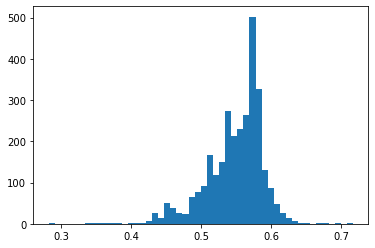

In [674]:
plt.hist(dirty_scores,bins=50)

In [568]:
df_gloved = df.copy()
df_gloved['dirty_scores'] = dirty_scores

ValueError: Length of values (1000) does not match length of index (570614)

In [565]:
df_gloved.to_csv('

2995.7235

In [562]:
dirty_scores

array(<generator object <genexpr> at 0x00000124821036D0>, dtype=object)